# Overview

This notebook provides various functions to plot the network results from the capacity expansion plan and subsequent dispatch model. 

In [34]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypsa.descriptors import get_switchable_as_dense as get_as_dense, expand_series, get_activity_mask

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
clean_names = {
    "coal": "Coal",
    "wind": "Wind",
    "biomass": "Biomass",
    "ccgt_steam": "HRSG + Steam Turbine",
    "solar_pv": "PV",
    "solar_csp": "CSP",
    "pumped hydro storage": "Pumped Hydro",
    "battery": "Battery",
    "ocgt": "OCGT Diesel/Gas",
    "other": "Hydro and Biomass"

}

In [55]:
network_wilcards = {
    'model_file': 'val-LC-UNC',
    'regions': '1-supply',
    'resarea': 'redz',
    'll': 'copt',
    'opts': 'LC'
}

path_template = "../networks/solved_{model_file}_{regions}_{resarea}_l{ll}_{opts}.nc"
network_path = path_template.format(**network_wilcards)
n = pypsa.Network(network_path)

INFO:pypsa.io:Imported network solved_val-LC-UNC_1-supply_redz_lcopt_LC.nc has buses, carriers, generators, loads, storage_units


In [37]:
old_path = "../results/networks/solved_val-LC-UNC-1_RSA_redz_lcopt_LC.nc"
nold = pypsa.Network(old_path)

INFO:pypsa.io:Imported network solved_val-LC-UNC-1_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units


# Line plotting

In [38]:
prop = "p_max_pu"
try:
    print(n.generators_t[prop].loc[2050, "RSA-coal-2050"].mean())
except:
    print(n.generators.loc["RSA-coal-2050", prop])

try:
    print(nold.generators_t[prop].loc[2050, "RSA coal_2050"].mean())
except:
    print(nold.generators.loc["RSA coal_2050", prop])

0.8970805589260246
0.7765621917808219


<Axes: xlabel='period,timestep'>

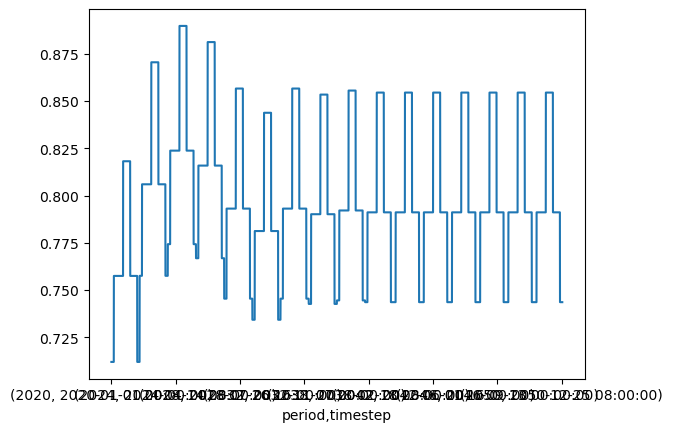

In [57]:
n.generators_t.p_max_pu["Kusile*"].plot()

In [39]:
y =2020
active = n.get_active_assets("Generator", y)
active_old = nold.get_active_assets("Generator", y)
coal_list = ['coal','sasol_coal']
cl = n.generators[active].query("carrier == @coal_list").index
clold = nold.generators[active_old].query("carrier == 'coal'").index

print(n.generators_t.p.loc[y, cl].sum(axis=1).mean()/(n.generators.loc[cl, "p_nom_opt"].sum()))
print(nold.generators_t.p.loc[y, clold].sum(axis=1).mean()/(nold.generators.loc[clold, "p_nom_opt"].sum()))

0.5867903518878168
0.5187552176703177


In [40]:
cl = n.generators.query("carrier == 'wind'").index
clold = nold.generators.query("carrier == 'onwind'").index

print(n.generators_t.p.loc[2050, cl].sum(axis=1).mean()/(n.generators.loc[cl, "p_nom_opt"].sum()))
print(nold.generators_t.p.loc[2050, clold].sum(axis=1).mean()/(nold.generators.loc[clold, "p_nom_opt"].sum()))

0.23851753424999292
0.25287573136966973


In [41]:
n_stats = n.statistics()
n_stats = (
    n_stats
    .reset_index()
    .rename({"level_0": "components", "level_1": "carriers"}, axis=1)
    .assign(carriers=lambda df: df["carriers"].str.lower())
    .set_index(["components", "carriers"])
)

n_stats_old = nold.statistics()
n_stats_old = (
    n_stats_old
    .reset_index()
    .rename({"level_0": "components", "level_1": "carriers"}, axis=1)
    .assign(carriers=lambda df: df["carriers"].str.lower())
    .set_index(["components", "carriers"])
)

In [42]:
scenario_csir = 'LC_UNC'
validation_file = pd.ExcelFile('../data/ambitions_validation.xlsx')
validation = pd.read_excel(
        validation_file,
        sheet_name=f'capacity_CSIR_{scenario_csir}',
        index_col=0,
    )/1000

validation['other'] = validation['hydro'] + validation['biomass']

validation.rename({"OCGT": "ocgt", "PHS":"pumped hydro storage", "solar":"solar_pv", "CSP":"solar_csp", "onwind":"wind"}, axis=1, inplace=True)
validation['ocgt'] += 0.7*validation['CCGT']
validation["ccgt_steam"] = 0.3*validation['CCGT']

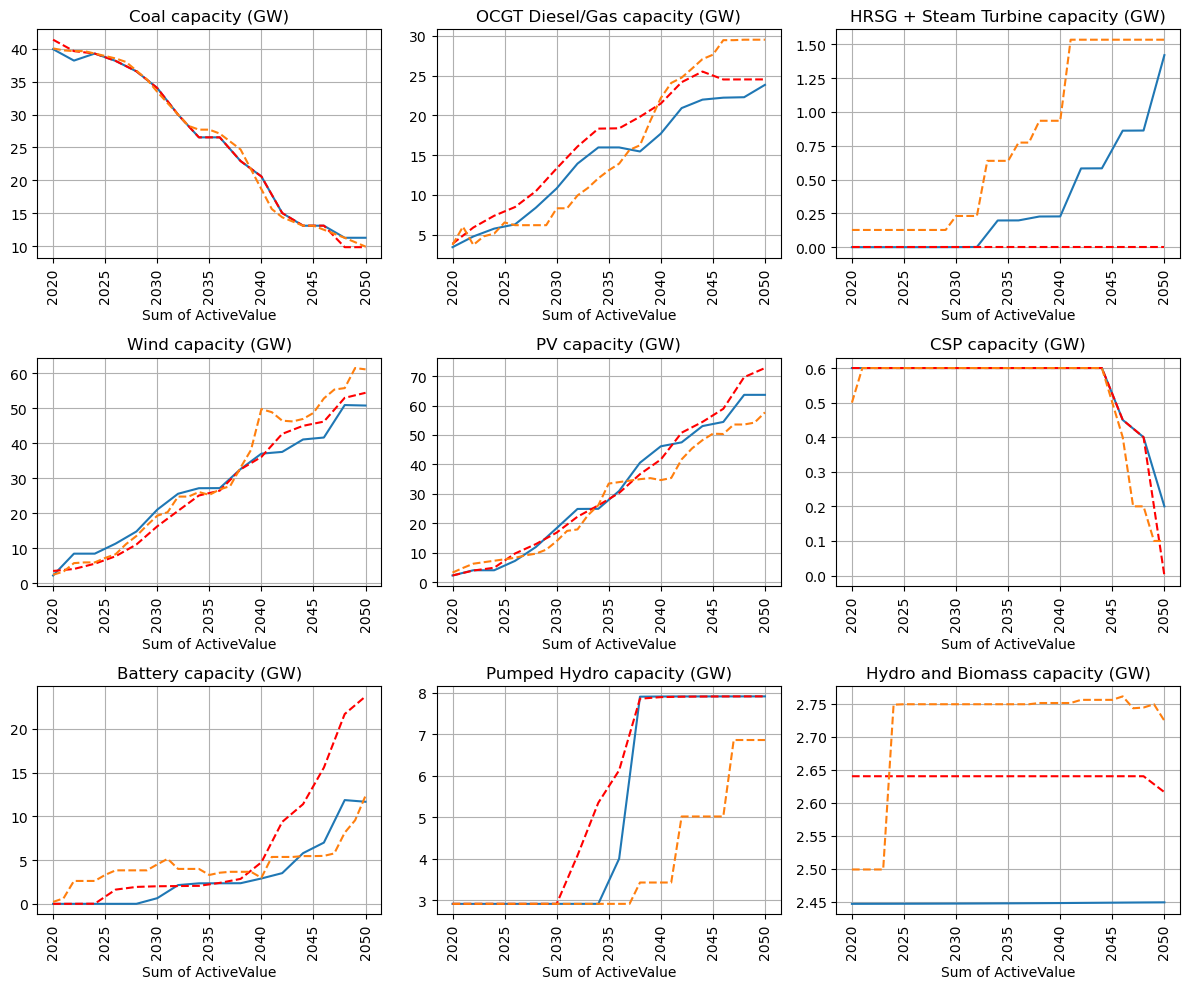

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
carrier_stats = n_stats.copy().droplevel(0)/1000
carrier_stats_old = n_stats_old.droplevel(0)/1000

carrier_stats_old.loc["ocgt"] +=0.7*carrier_stats_old.loc["ccgt"]
carrier_stats_old.loc["ccgt_steam"] = 0.3*carrier_stats_old.loc["ccgt"]
carrier_stats_old.loc["wind"] = carrier_stats_old.loc["onwind"]
carrier_stats_old.loc["solar_pv"] = carrier_stats_old.loc["solar"]
carrier_stats_old.loc["solar_csp"] = carrier_stats_old.loc["csp"]
carrier_stats_old.loc["hydro_import"] = carrier_stats_old.loc["hydro-import"]

carriers = ['coal', 'ocgt', 'ccgt_steam', 'wind', 'solar_pv', 'solar_csp', 'battery', 'pumped hydro storage', 'other']

for i, carrier in enumerate(carriers):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    if carrier == "coal":
        carrier_stats.loc[["coal","sasol_coal"], "Optimal Capacity"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc["coal", "Optimal Capacity"].plot(ax=ax, color= 'r', ls = "--")
        validation["coal"].plot(ax=ax, ls="--")     
    elif carrier == "ocgt":
        carrier_stats.loc[["ocgt_gas","ocgt_diesel"], "Optimal Capacity"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc[["ocgt","diesel","gas"], "Optimal Capacity"].sum(axis=0).plot(ax=ax, color= 'r', ls = "--")
        validation["ocgt"].plot(ax=ax, ls="--")
    elif carrier == "other":
        carrier_stats.loc[["hydro","biomass","hydro_import"], "Optimal Capacity"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc[["hydro","biomass","hydro_import"], "Optimal Capacity"].sum(axis=0).plot(ax=ax, color= 'r', ls = "--")
        validation[["hydro","biomass"]].sum(axis=1).plot(ax=ax, ls="--")
    else:
        carrier_stats.loc[carrier, "Optimal Capacity"].plot(ax=ax)
        carrier_stats_old.loc[carrier, "Optimal Capacity"].plot(ax=ax, color= 'r', ls = "--")
        validation[carrier].plot(ax=ax, ls="--")

    ax.set_title(clean_names[carrier] + " capacity (GW)")
    #ax.xaxis.set_major_formatter(lambda x, pos: f"{int(x)}")
    #ax.set_xlim(2020, 2050)
    #ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)

plt.tight_layout()  


In [44]:
validation_file = pd.ExcelFile('../data/ambitions_validation.xlsx')
validation = pd.read_excel(
        validation_file,
        sheet_name=f'energy_CSIR_{scenario_csir}',
        index_col=0,
    )/1000

validation['other'] = validation['hydro'] + validation['biomass']

validation.rename({"OCGT": "ocgt", "PHS":"pumped hydro storage", "solar":"solar_pv", "CSP":"solar_csp", "onwind":"wind"}, axis=1, inplace=True)
validation['ocgt'] += 0.7*validation['CCGT']
validation["ccgt_steam"] = 0.3*validation['CCGT']

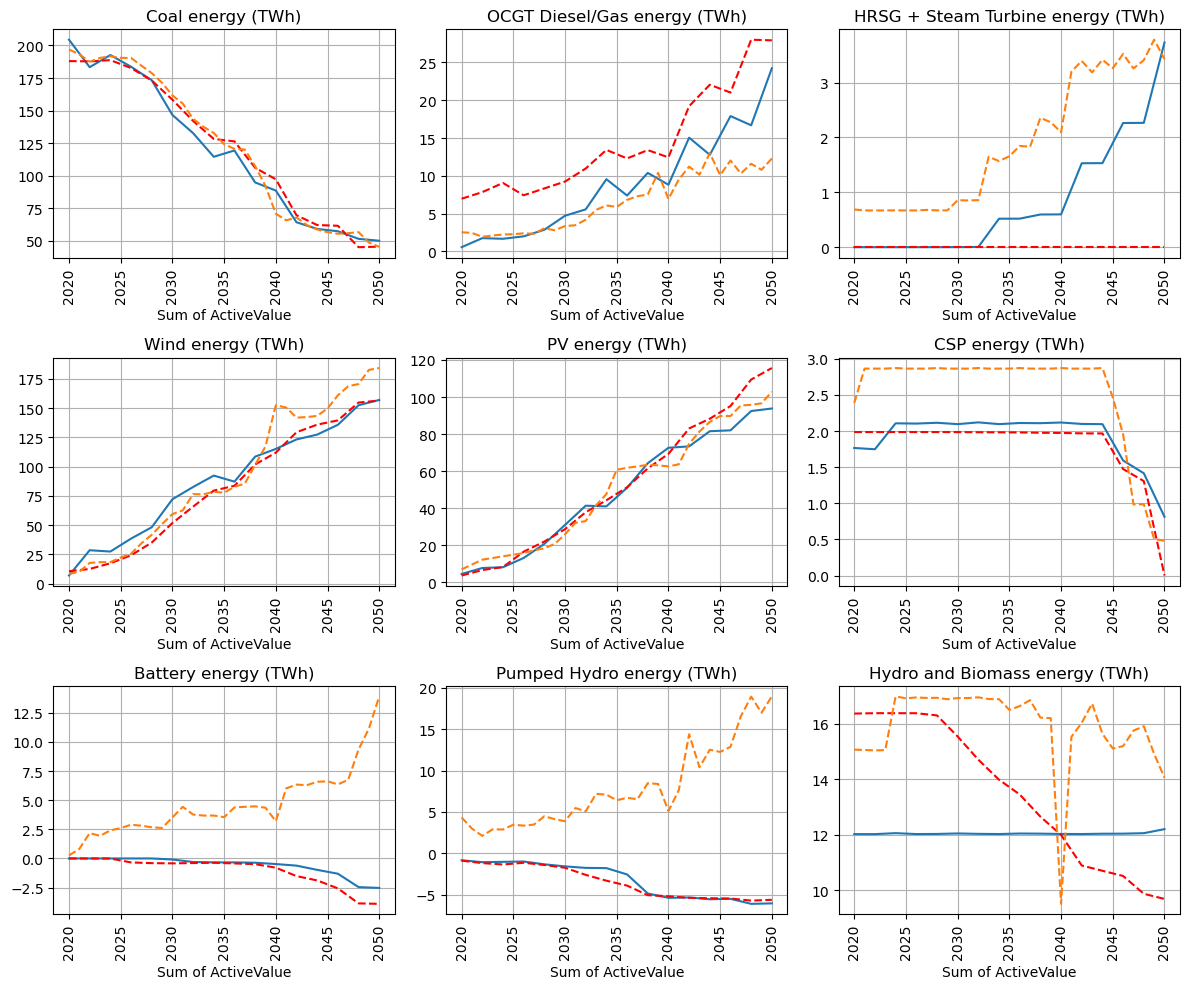

In [45]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
carrier_stats = n_stats.copy().droplevel(0)/1e6
carrier_stats_old = n_stats_old.droplevel(0)/1e6

carrier_stats_old.loc["ocgt"] +=0.7*carrier_stats_old.loc["ccgt"]
carrier_stats_old.loc["ccgt_steam"] = 0.3*carrier_stats_old.loc["ccgt"]
carrier_stats_old.loc["wind"] = carrier_stats_old.loc["onwind"]
carrier_stats_old.loc["solar_pv"] = carrier_stats_old.loc["solar"]
carrier_stats_old.loc["solar_csp"] = carrier_stats_old.loc["csp"]
carrier_stats_old.loc["hydro_import"] = carrier_stats_old.loc["hydro-import"]

carriers = ['coal', 'ocgt', 'ccgt_steam', 'wind', 'solar_pv', 'solar_csp', 'battery', 'pumped hydro storage', 'other']

for i, carrier in enumerate(carriers):
    row, col = divmod(i, 3)
    ax = axs[row, col]

    if carrier == "coal":
        carrier_stats.loc[["coal","sasol_coal"], "Dispatch"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc["coal", "Dispatch"].plot(ax=ax, color= 'r', ls = "--")
        validation["coal"].plot(ax=ax, ls="--")  
    elif carrier == "ocgt":
        carrier_stats.loc[["ocgt_gas","ocgt_diesel"], "Dispatch"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc[["ocgt","diesel","gas"], "Dispatch"].sum(axis=0).plot(ax=ax, color= 'r', ls = "--")
        validation["ocgt"].plot(ax=ax, ls="--")
    elif carrier == "other":
        carrier_stats.loc[["hydro","biomass","hydro_import"], "Dispatch"].sum(axis=0).plot(ax=ax)
        carrier_stats_old.loc[["hydro","biomass","hydro_import"], "Dispatch"].sum(axis=0).plot(ax=ax, color= 'r', ls = "--")
        validation[["hydro","biomass"]].sum(axis=1).plot(ax=ax, ls="--")
    else:
        carrier_stats.loc[carrier, "Dispatch"].plot(ax=ax)
        carrier_stats_old.loc[carrier, "Dispatch"].plot(ax=ax, color= 'r', ls = "--")
        validation[carrier].plot(ax=ax, ls="--")

    ax.set_title(clean_names[carrier] + " energy (TWh)")
    #ax.xaxis.set_major_formatter(lambda x, pos: f"{int(x)}")
    #ax.set_xlim(2020, 2050)
    #ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)

plt.tight_layout()  


In [46]:
y=2030
coal_list = ['coal', 'sasol_coal']
cl = n.generators.query("carrier in @coal_list").index

en = pd.DataFrame(index = cl, columns = ["new", "old"])
pu = en.copy()
cst = en.copy()
en["new"] = n.generators_t.p.loc[y, cl].sum()
pu["new"] = get_as_dense(n, "Generator", "p_max_pu").loc[y, cl].mean()
cst["new"] = get_as_dense(n, "Generator", "marginal_cost").loc[y, cl].mean()


coal_list = ['coal']
cl = nold.generators.query("carrier in @coal_list").index
en["old"] = nold.generators_t.p.loc[y, cl].sum()
en.loc["Sasol_coal", "old"] = nold.generators_t.p.loc[y, "Sasol SSF"].sum()
pu["old"] = get_as_dense(nold, "Generator", "p_max_pu").loc[y, cl].mean()
pu.loc["Sasol_coal", "old"] = get_as_dense(nold, "Generator", "p_max_pu").loc[y, "Sasol SSF"].mean()
cst["old"] = get_as_dense(nold, "Generator", "marginal_cost").loc[y, cl].mean()
cst.loc["Sasol_coal", "old"] = get_as_dense(nold, "Generator", "marginal_cost").loc[y, "Sasol SSF"].mean()

<Axes: xlabel='Generator'>

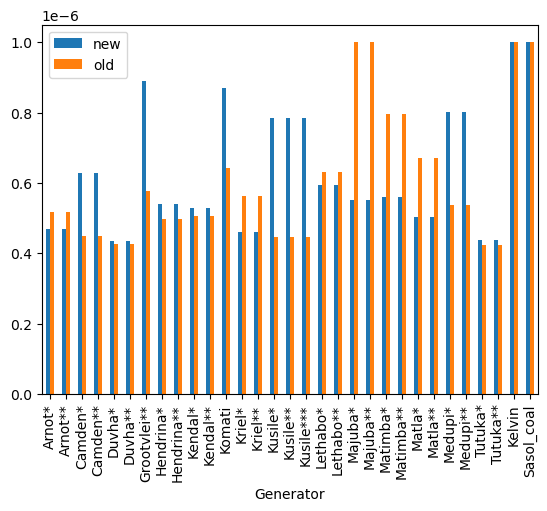

In [47]:
(pu.iloc[0:31]/1e6).plot.bar()

In [48]:
en.iloc[0:31].sum()["new"]/en.iloc[0:31].sum()["old"]

0.20901359955588017

In [49]:
en.iloc[0:31].sum()

new    3.309386e+07
old    1.583335e+08
dtype: float64

<Axes: xlabel='Generator'>

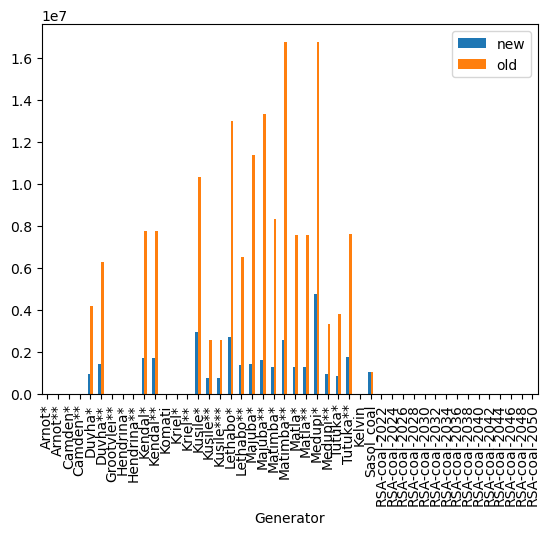

In [50]:
en.plot.bar()

<Axes: xlabel='timestep'>

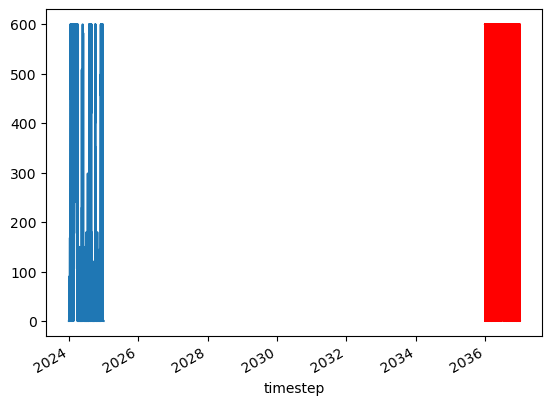

In [51]:
n.generators_t.p.loc[2036, "Sasol_coal"].plot(color='r')
nold.generators_t.p.loc[2024, "Sasol SSF"].plot()

In [52]:
n.objective/1e12

2.039959268465013

In [53]:
nold.objective/1e12

2.0396464572532937

In [54]:
y=2040
cl = n.generators.query("carrier == 'coal' & p_nom_extendable == False").index
n.generators_t.p_max_pu.loc[y,cl].mean(axis=1).plot()
clold = nold.generators.query("carrier == 'coal' & p_nom_extendable == False").index
get_as_dense(nold, "Generator", "p_max_pu").loc[y, clold].mean(axis=1).plot()

KeyError: "['Kelvin'] not in index"

In [ ]:
nold.generators[nold.generators.carrier=="coal"]

,bus,carrier,build_year,lifetime,p_nom,p_nom_extendable,efficiency,ramp_limit_up,ramp_limit_down,marginal_cost,...,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down,weight,n_mod
Generator,,,,,,,,,,,,,,,,,,,,,
Arnot*,RSA,coal,2020,6.0,1116.0,False,0.268717,0.112903,0.112903,444.992370,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Arnot**,RSA,coal,2020,10.0,1116.0,False,0.268717,0.112903,0.112903,444.991685,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Camden*,RSA,coal,2020,1.0,740.0,False,0.252101,0.089189,0.089189,559.253826,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Camden**,RSA,coal,2020,4.0,370.0,False,0.252101,0.178378,0.178378,559.253637,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Duvha*,RSA,coal,2020,11.0,1150.0,False,0.283800,0.172174,0.172174,326.340796,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Duvha**,RSA,coal,2020,14.0,1725.0,False,0.283800,0.114783,0.114783,326.339787,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Grootvlei*,RSA,coal,2020,-1.0,286.0,False,0.248327,0.188811,0.188811,530.021052,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Grootvlei**,RSA,coal,2020,0.0,286.0,False,0.248327,0.188811,0.188811,530.019826,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0
Hendrina*,RSA,coal,2020,1.0,440.0,False,0.258139,0.150000,0.150000,498.260338,...,0.0,0.0,0,0,1,0,1.0,1.0,1.0,0


<Axes: xlabel='timestep'>

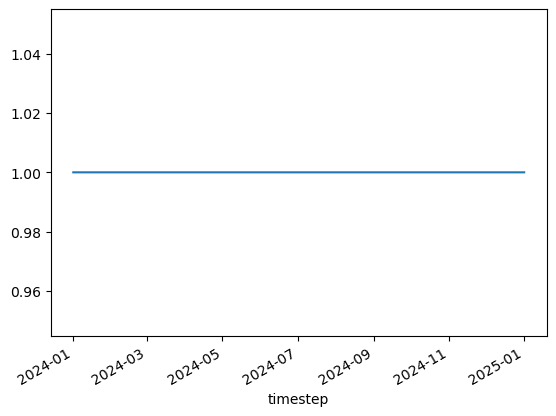

In [ ]:
get_as_dense(nold, "Generator", "p_max_pu").loc[2024, clold]["Majuba*"].plot()

<Axes: xlabel='timestep'>

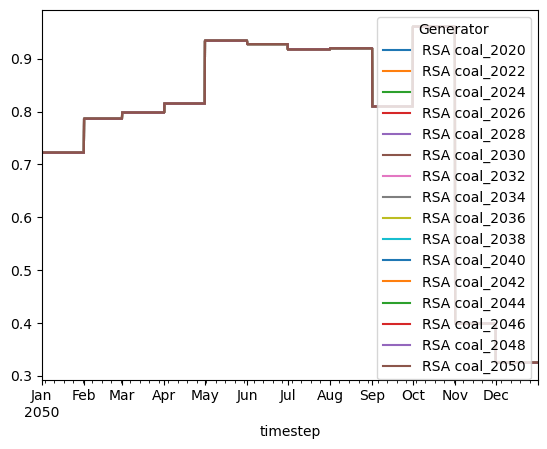

In [ ]:
cl_old = nold.generators.query("carrier == 'coal' & p_nom_extendable").index
nold.generators_t.p_max_pu.loc[2050,cl_old].plot()

In [ ]:
n.generators.to_clipboard()

In [ ]:
nold.generators.p_min_pu.loc[cl_old].max()

0.0

In [ ]:
n.objective/1e9

2027.19561825582

<Axes: xlabel='timestep'>

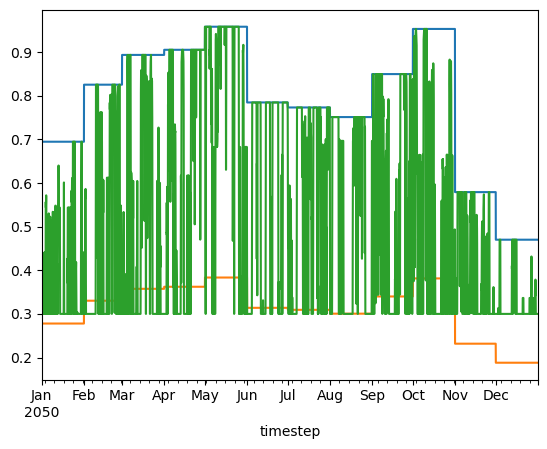

In [ ]:
cl = n.generators[n.get_active_assets("Generator", 2050)].query("carrier=='coal'").index
p_nom = n.generators.loc[cl].p_nom_opt.sum()

p_max = (n.generators.p_nom_opt.loc[cl]*n.generators_t.p_max_pu.loc[2050, cl]).sum(axis=1)
(p_max/p_nom).plot()
(0.4*p_max/p_nom).plot()
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).plot()

In [ ]:
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).mean()

0.5236161609008789

<Axes: xlabel='timestep'>

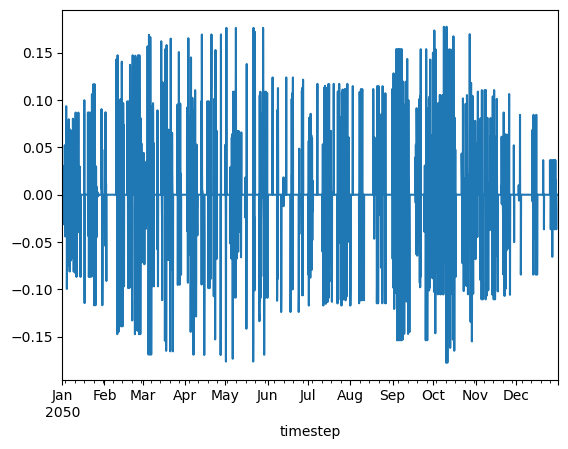

In [ ]:
(n.generators_t.p.loc[2050, cl].sum(axis=1).diff()/p_nom).plot()

<Axes: xlabel='timestep'>

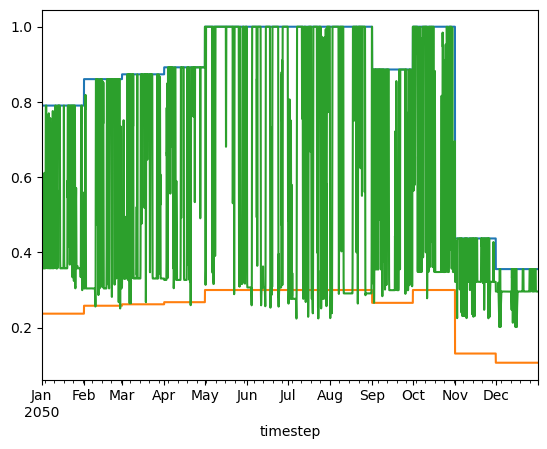

In [ ]:
cl = n.generators[n.get_active_assets("Generator", 2050)].query("carrier=='coal' & p_nom_extendable").index
p_nom = n.generators.loc[cl].p_nom_opt.sum()

p_max = (n.generators.p_nom_opt.loc[cl]*n.generators_t.p_max_pu.loc[2050, cl]).sum(axis=1)
(p_max/p_nom).plot()
(0.3*p_max/p_nom).plot()
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).plot()

In [ ]:
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).mean()

0.6000000010674716

<Axes: xlabel='timestep'>

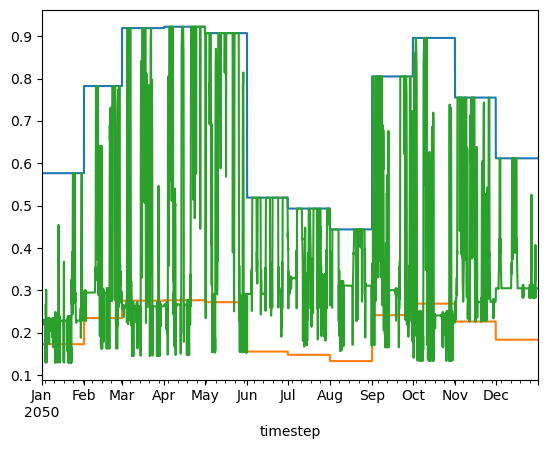

In [ ]:
cl = n.generators[n.get_active_assets("Generator", 2050)].query("carrier=='coal' & p_nom_extendable == False").index
p_nom = n.generators.loc[cl].p_nom_opt.sum()

p_max = (n.generators.p_nom_opt.loc[cl]*n.generators_t.p_max_pu.loc[2050, cl]).sum(axis=1)
(p_max/p_nom).plot()
(0.3*p_max/p_nom).plot()
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).plot()

In [ ]:
(n.generators_t.p.loc[2050, cl].sum(axis=1)/p_nom).mean()

0.4291759725881075

<Axes: xlabel='timestep'>

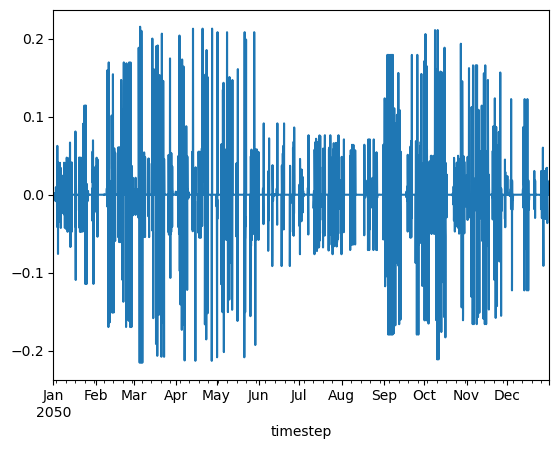

In [ ]:
(n.generators_t.p.loc[2050, cl].sum(axis=1).diff()/p_nom).plot()

In [ ]:
n.generators.loc["RSA-coal-2050"]

bus                                   RSA
carrier                              coal
lifetime                             50.0
build_year                           2050
p_nom                                 0.0
efficiency                       0.366898
ramp_limit_up                        0.15
ramp_limit_down                      0.15
marginal_cost                      490.48
capital_cost               5162778.312372
ramp_limit_start_up                  0.25
ramp_limit_shut_down                 0.25
start_up_cost                         0.0
shut_down_cost                        0.0
min_up_time                             4
min_down_time                           2
p_nom_extendable                     True
plant_name                  RSA-coal-2050
p_nom_opt                     2905.816347
control                                PQ
type                                     
p_nom_mod                             0.0
p_nom_min                             0.0
p_nom_max                         

In [ ]:
nold.generators.loc["RSA coal_2048"]

bus                                   RSA
carrier                              coal
build_year                           2048
lifetime                             50.0
p_nom                                 0.0
p_nom_extendable                     True
efficiency                       0.366898
ramp_limit_up                         NaN
ramp_limit_down                       NaN
marginal_cost                  429.655976
capital_cost               5162778.312372
plant_name                  RSA coal_2048
control                                PQ
p_nom_opt                        1.217209
type                                     
p_nom_mod                             0.0
p_nom_min                             0.0
p_nom_max                             inf
p_min_pu                              0.0
p_max_pu                              1.0
p_set                                 0.0
q_set                                 0.0
sign                                  1.0
marginal_cost_quadratic           